In [11]:
import math
import random
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np 
import optuna
from optuna import create_study, logging
import pandas as pd
import plotly.express as px
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from optuna.integration import XGBoostPruningCallback
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
import umap.umap_ as umap
import xgboost as xgb
from scipy.io import arff

In [12]:
arff_file = arff.loadarff('/workspaces/2025SE-Mike.N-HSC-AT2/data/cement.arff')
concrete_data = pd.DataFrame(arff_file[0])

In [13]:
concrete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cement              1030 non-null   float64
 1   blast_furnace_slag  1030 non-null   float64
 2   fly_ash             1030 non-null   float64
 3   water               1030 non-null   float64
 4   superplasticizer    1030 non-null   float64
 5   coarse_aggregate    1030 non-null   float64
 6   fine_aggregate      1030 non-null   float64
 7   age                 1030 non-null   float64
 8   strength            1030 non-null   float64
dtypes: float64(9)
memory usage: 72.6 KB


In [14]:
concrete_data.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


In [15]:
train, test = train_test_split(concrete_data, test_size=0.2)
train = train.rename(columns = {'2015 PRICE VAR [%]': '2015 PRICE VAR'})

In [16]:
train_y = train['strength'].copy()
train = train.drop(['strength'], axis = 1)
numerical_features = train.select_dtypes(['number']).columns
categorical_features = train.select_dtypes(['object']).columns

In [17]:
pd.DataFrame((test==0).sum()/len(test), columns=["zero_rate"])\
    .style.bar(subset=['zero_rate'], color='#20c8f2')

,zero_rate
cement,0.000000
blast_furnace_slag,0.436893
fly_ash,0.558252
water,0.000000
superplasticizer,0.393204
coarse_aggregate,0.000000
fine_aggregate,0.000000
age,0.000000
strength,0.000000


Some columns have a large number of 0s.\
This maybe because of a choice in cement ingredients or missing data.\
Careful handling is needed to prevent to much data loss.\
Using imputers is recommended rather than dropping 0s.

<Axes: ylabel='Frequency'>

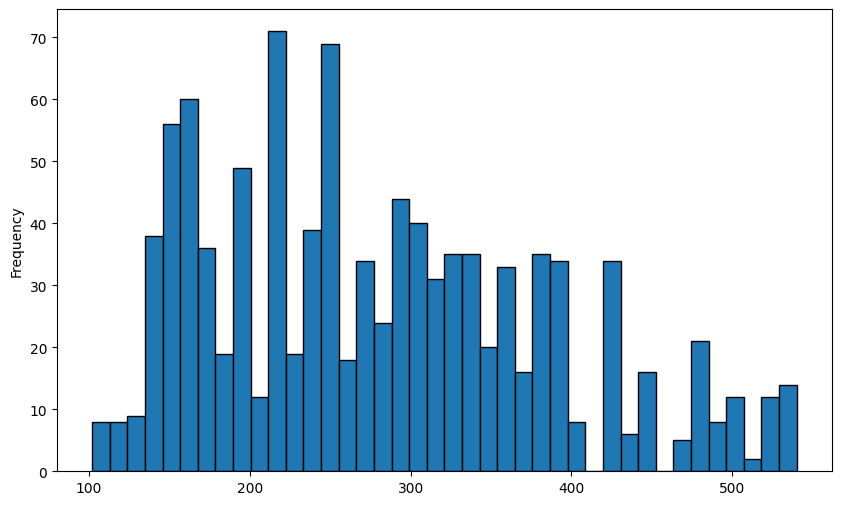

In [25]:
#Univariate
#2014
concrete_data['cement'].plot(kind='hist', bins=40, edgecolor='black', figsize=(10, 6))

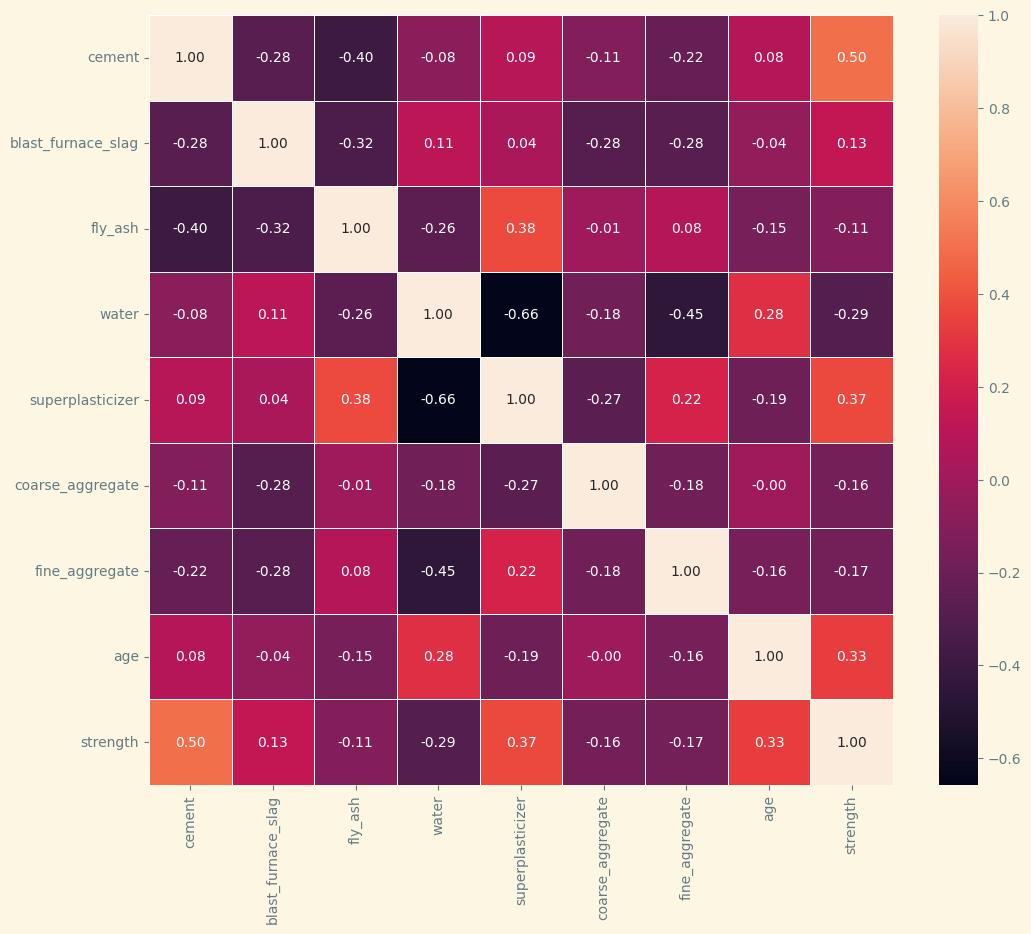

In [38]:
fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches
corr_matrix = concrete_data.corr()
heatmap = sns.heatmap(corr_matrix, annot = True, linewidth = .5, fmt='.2f', ax=ax)

Bottom column shows the correlation between the target and features\
The amount of Cement, Superplaticizer and Age affected the strength of concrete most strongly.\
Ratios of these materials to water are possible avenues for feature engineering.

In [26]:
feature_cols = [x for x in train.columns]

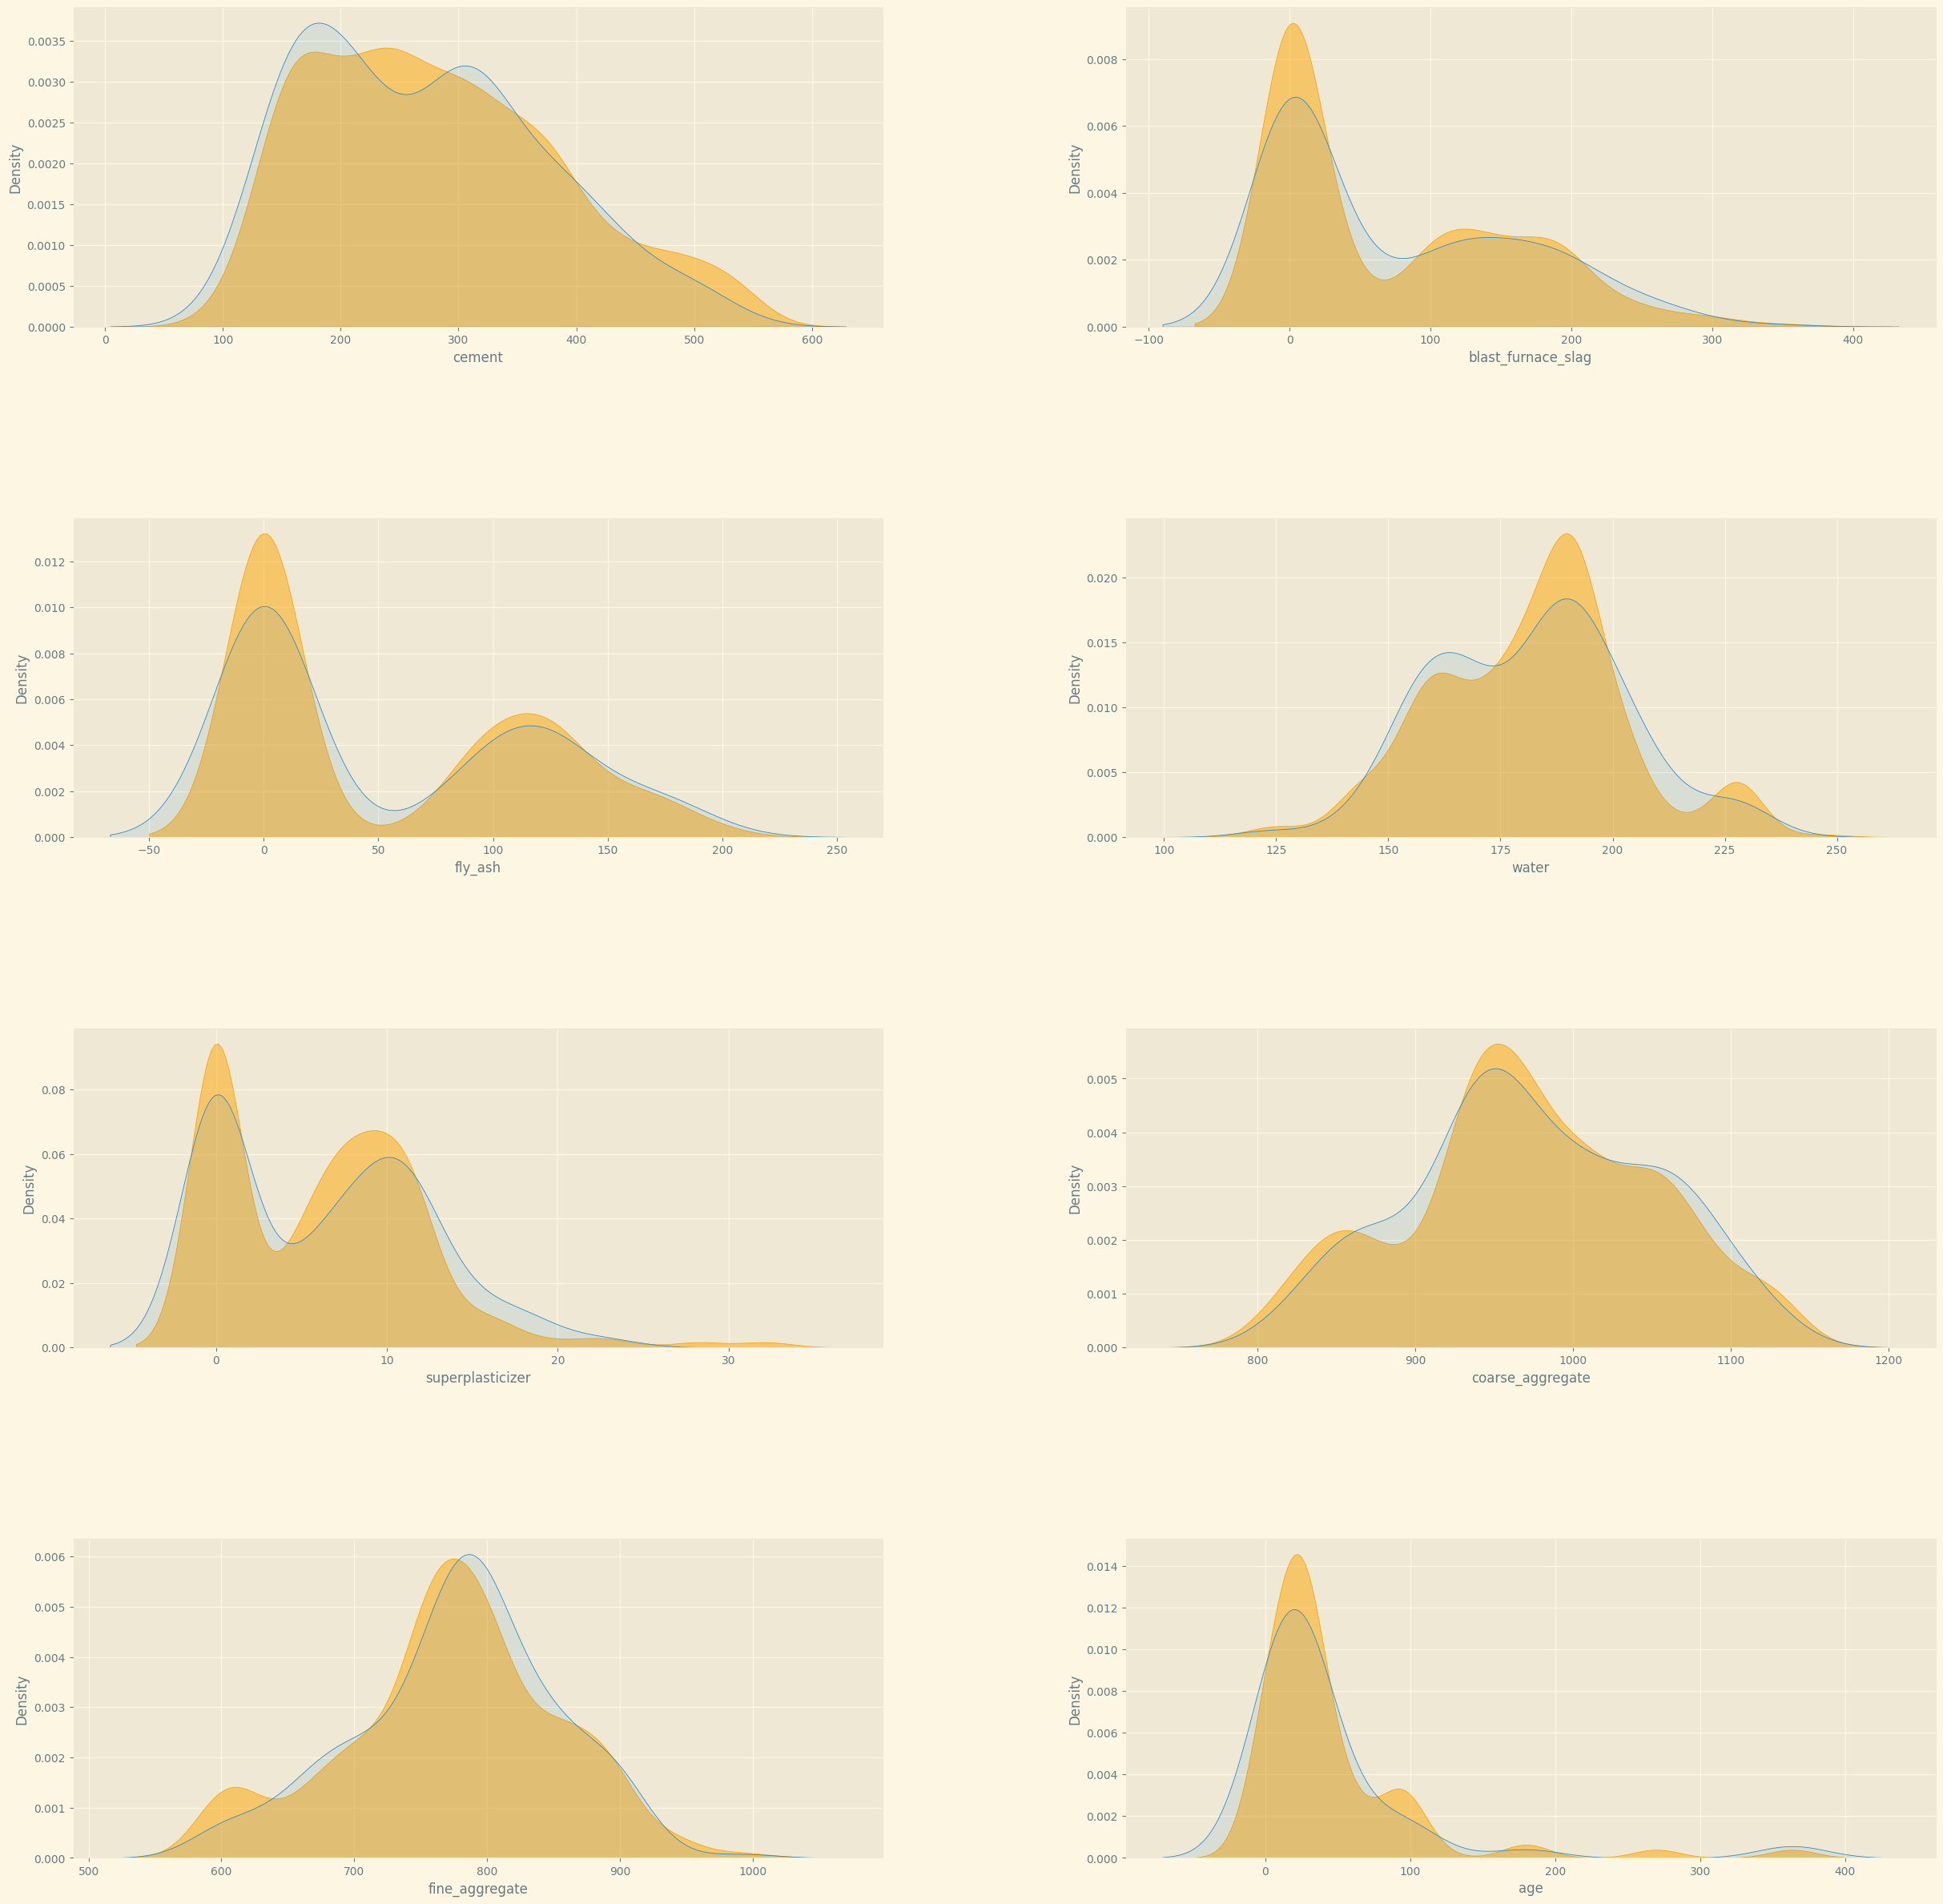

In [31]:
#Graphing the distributions of data points in each column, with the training data in orange and the test data in blue.
plt.style.use("Solarize_Light2")

fig, axes = plt.subplots(4, 2, figsize=(30, 30), gridspec_kw=dict(wspace=0.3, hspace=0.6))
for col, ax in zip(feature_cols, axes.flatten()):
    if train[col].dtype == 'object' or train[col].dtype == 'other':
        continue
    sns.kdeplot(x=train[col], ax=ax, alpha=0.5, fill=True, linewidth=0.6, color='orange')
    sns.kdeplot(x=test[col], ax=ax, alpha=0.1, fill=True, linewidth=0.6)


Distributions in test data generally aligns with training data.

### Dimensionality Reduction

The dataset has 224 feature columns, which leads to long training time and unnecessary complexity, i.e. The Curse of Dimensionality.\
Principle Component Analysis is a framework to reduce dimensionality while keeping the most of the information by maximizing variance.\
UMAP is a visualising framework that shows the similarities between observations to identify clusters and outliers. 

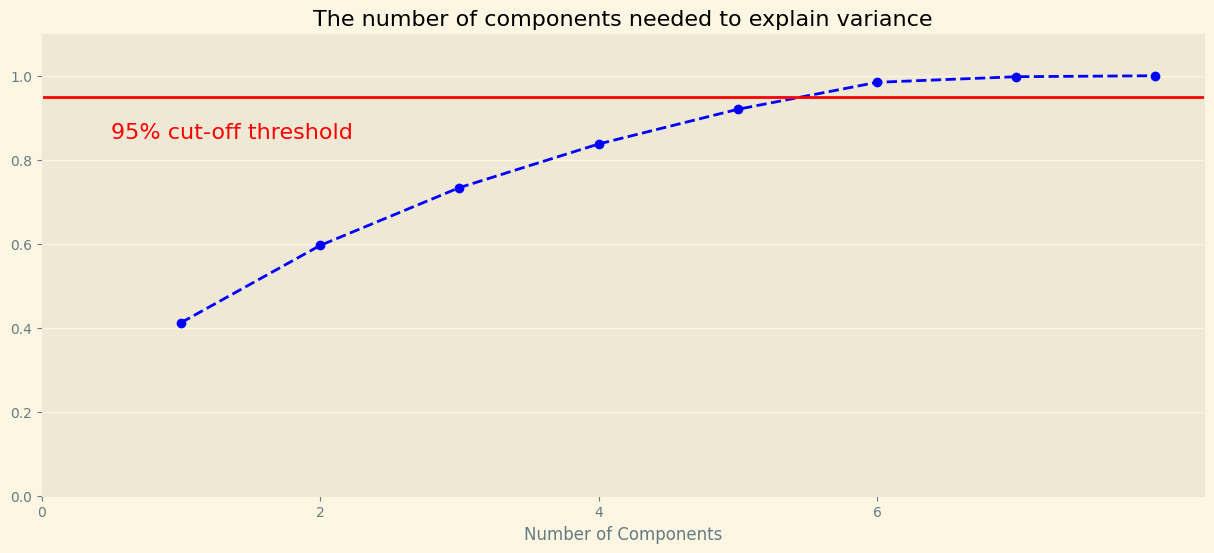

In [32]:
scaler = RobustScaler()
imputer = SimpleImputer(strategy='mean')

train[numerical_features] = imputer.fit_transform(train[numerical_features])
train[numerical_features] = scaler.fit_transform(train[numerical_features])
pca = PCA().fit(train[numerical_features].fillna(0))

plt.rcParams["figure.figsize"] = (15,6)

fig, ax = plt.subplots()
xi = np.arange(1, len(numerical_features)+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(numerical_features), step=2))

plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [33]:
# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed to explain 95% of the variance
num_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1

print(f"The lowest number of principal components needed to explain 95% of the variance is: {num_components_95}")

The lowest number of principal components needed to explain 95% of the variance is: 6


In [34]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(train[numerical_features].fillna(0))

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Text(0.5, 1.0, 'UMAP projection of train data')

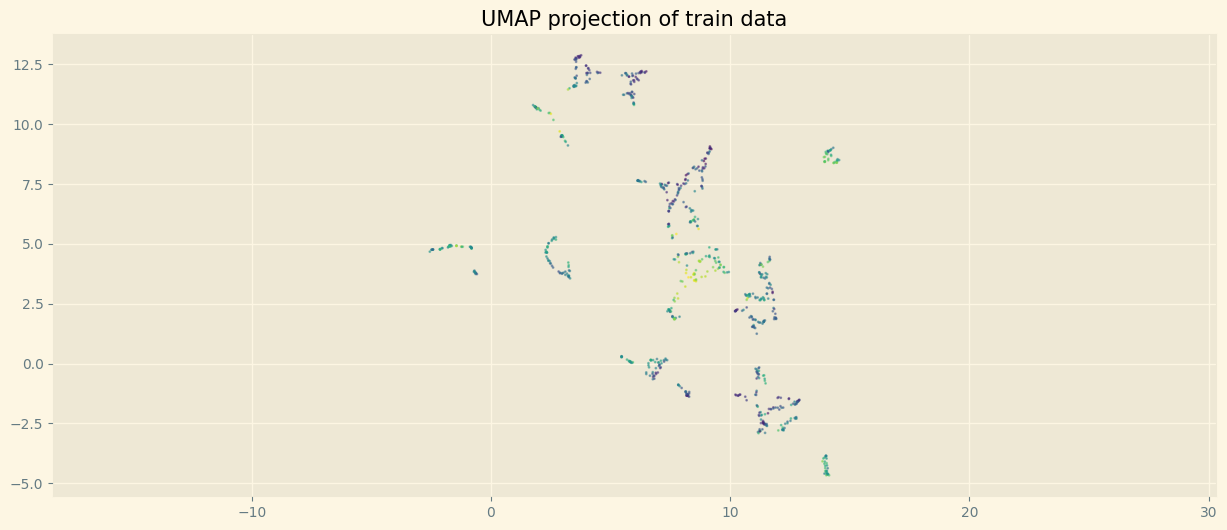

In [36]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=train_y,
    s=1,
    alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of train data', fontsize=15)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Text(0.5, 1.0, 'UMAP projection of train data after PCA')

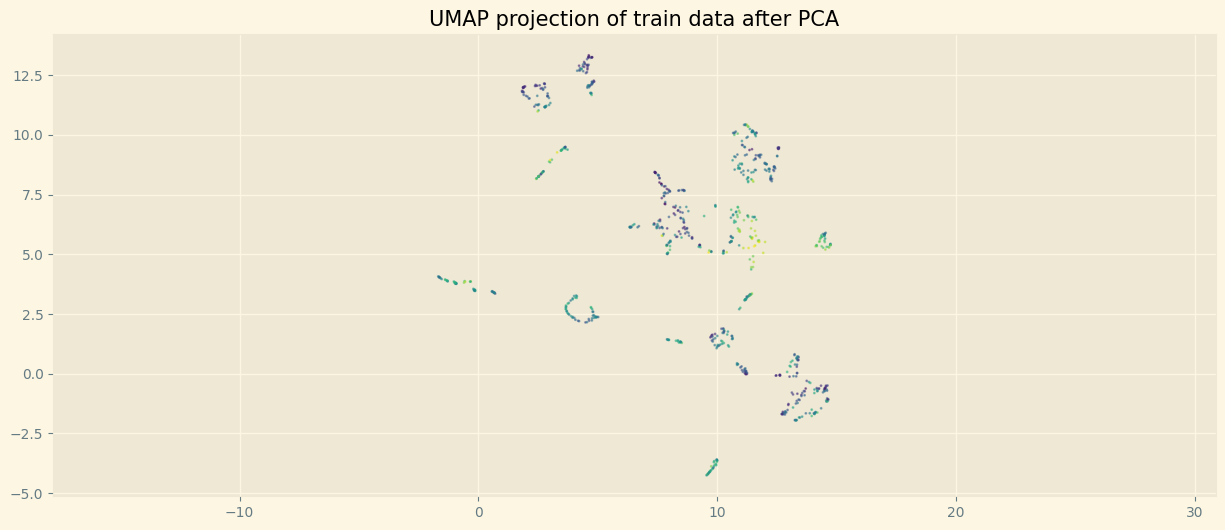

In [37]:
pca = PCA(n_components=6).fit(train[numerical_features].fillna(0))
df_pca = pca.transform(train[numerical_features].fillna(0))

reducer = umap.UMAP()
embedding = reducer.fit_transform(df_pca)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=train_y,
    s=1,
    alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of train data after PCA', fontsize=15)

UMAP stays the same after PCA, suggesting that dimensionality reduction is possible.\
The dataset only has 8 feature columns, which is not high in complexity.\
For better user experience, asking for only 6 features should be enough.